## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [ ]:
 import numpy as np
 import numba
 from numba import cuda , vectorize, int64, float32, float64
 @vectorize([float32(float32)])
 def exp(x):
   return np.exp(x)
 def log(x):
   return np.log(x)

A = np.asarray([2, 5, 10, 3, 8]).astype(np.float32)

print(log(A))
print(exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

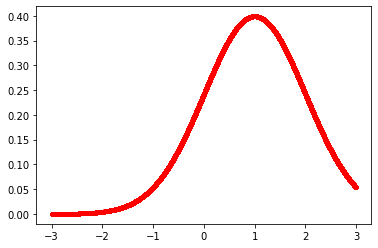

In [ ]:
import math as m
import matplotlib.pyplot as plt

@vectorize([float64(float64, int64, int64)])
def gaussian(x, mean,sigma):
  return 1./(m.sqrt(2.*m.pi)*sigma)*m.exp(-m.pow((x - mean)/sigma, 2.)/2)

x = np.random.uniform(-3,3, 100000)
mean = 1
sigma = 1
y=gaussian(x,mean, sigma)
plt.plot(x,y, '.', color='red')

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

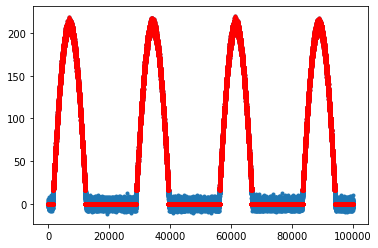

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

plt.plot(data, '.')

@vectorize([float64(float64, int64)])
def zero_supp(x, treshold):
  if x <= 15:
    return 0
  else:
     return x

threshold = 15
data = zero_supp(data, threshold)
plt.plot(data, '.', color='red')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [ ]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

from numba import cuda
import math

X = np.random.rand(3,3).astype('float64')
Y = np.random.rand(3,3).astype('float64')
res = np.zeros((3,3), dtype='float64')


@cuda.jit
def sigmoid_kernel(x, y, result, a, c):    
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(a * tmp + c)

        
sigmoid_kernel[(1,1),(3,3)](X, Y, res, 1., 1.)

print(res)




[[0.95064036 0.89541271 0.8899454 ]
 [0.98361173 0.95202567 0.9511515 ]
 [0.9787001  0.95269626 0.91624154]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:

M = np.random.rand(256,256,256)

@cuda.jit
def cosine_kernel(M):
  row, col, side = cuda.grid(3)
  if row < M.shape[0] and col < M.shape[1] and side <M.shape[2]:
    M[row][col][side] = math.cos(M[row][col][side])
 
 
threadsperblock = (8,8,8)
blockspergrid_x = int(math.ceil(M.shape[0] / threadsperblock[0]))
blockspergrid_y = math.ceil(M.shape[1]/threadsperblock[1])
blockspergrid_z = math.ceil(M.shape[2]/threadsperblock[2])

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cosine_kernel[blockspergrid, threadsperblock](M)
M

array([[[0.60279812, 0.76975434, 0.60877687, ..., 0.99997284,
         0.99856529, 0.99998013],
        [0.62449594, 0.96700957, 0.67787705, ..., 0.98115367,
         0.86403785, 0.90995394],
        [0.97777306, 0.62175195, 0.72098429, ..., 0.72310071,
         0.69286988, 0.98702445],
        ...,
        [0.97510547, 0.68014096, 0.83150018, ..., 0.68417102,
         0.58463803, 0.99775865],
        [0.72873852, 0.62671836, 0.97090359, ..., 0.58914135,
         0.97221979, 0.97727025],
        [0.84405897, 0.67720094, 0.94010485, ..., 0.56606401,
         0.99905522, 0.76694352]],

       [[0.84515907, 0.80060623, 0.992698  , ..., 0.80731627,
         0.93580626, 0.89691484],
        [0.85692563, 0.67963484, 0.78500167, ..., 0.99398345,
         0.89896287, 0.92746801],
        [0.96904509, 0.97512536, 0.93886036, ..., 0.761213  ,
         0.55363794, 0.76330402],
        ...,
        [0.9881316 , 0.79402168, 0.9383476 , ..., 0.81881317,
         0.77033657, 0.96324681],
        [0.9

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.rand(24,12)
B = np.random.rand(12,22)
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (8,8)
blockspergrid_x = math.ceil(M.shape[0]/threadsperblock[0])
blockspergrid_y = math.ceil(M.shape[1]/threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
C


array([[3.09071444, 3.01256656, 2.91440121, 4.49247722, 3.76086441,
        2.63724231, 3.90773543, 2.14353276, 3.28968105, 3.63950353,
        3.9106022 , 2.40238657, 2.21418609, 3.03678341, 4.15279926,
        2.25693917, 3.40949774, 2.65136402, 3.94331384, 2.64567639,
        2.68309284, 3.56973136],
       [3.84690366, 3.8488049 , 4.23254674, 5.39551143, 4.54693016,
        3.76963477, 4.66723127, 3.01075479, 3.76019681, 4.68868345,
        5.31880485, 3.27052283, 2.30523742, 4.20878311, 5.0669338 ,
        2.48375825, 4.11328643, 3.4792221 , 4.97793989, 3.15882977,
        3.29247241, 4.19144434],
       [3.21564144, 3.34032847, 3.70826574, 4.82523865, 4.16300543,
        3.11604466, 4.0435821 , 2.70375041, 3.1710021 , 4.38225262,
        4.19074495, 2.68091152, 2.55222861, 3.25859149, 3.95889327,
        2.61409901, 3.99834215, 2.45716378, 4.06267363, 3.05517486,
        2.80865675, 3.50720515],
       [3.76713272, 3.29183425, 3.72832316, 5.43555252, 4.62435729,
        3.0827010